# Chapter 2
### Perceptrons and adaptive linear neurons

In [5]:
# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%matplotlib inline
plt.style.use('ggplot')

### Perceptrons theory

Linear classifiers that take motivation from neurons. They can predict one of two classes, 1 and -1, for some vector of inputs $\boldsymbol{x}$. If inputting $\boldsymbol{x}$ into the perceptron results in a "signal" greater than a threshold $\theta$ then class 1 is predicted else class -1 is given.

$$
\phi(z) = 
    \begin{cases}
     1 &\text{if \(z \ge \theta\)} \\
     -1 &\text{otherwise}
    \end{cases}
$$

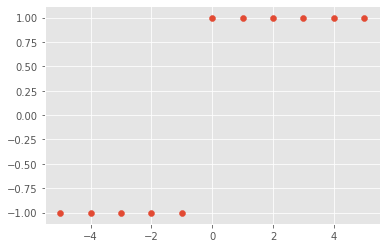

In [7]:
x = np.arange(-5,6)
# alternatively 
# np.where(np.arange(-5,6) >= 0, 1, -1)
y = x * 1/np.abs(x)
y[np.isnan(y)] = 1
plt.scatter(x, y);

In [8]:
def classify(w, z, threshold):
    return 1 if signalify(w, z) >= threshold else -1

For simplicity the threshold is usually rearranged in the decision rule and moved into the signal function $z(\boldsymbol{w}, \boldsymbol{x})$

The signal is simply the dot product of the weights $\boldsymbol{w}$ and the input $\boldsymbol{x}$ less the threshold:
$$z(\boldsymbol{w}, \boldsymbol{x}) = \boldsymbol{w}^{T}\boldsymbol{x} - \theta$$

In [9]:
def signalify(w, z):
    return np.dot(w,z)

#### Updating algorithm
The perceptron updates its vector of weights $\boldsymbol{w}$ each time it makes a prediction $\hat{y_i}$ using inputs $\boldsymbol{x_i}$.

This is done for all weights using the following updating rule:
$$\boldsymbol{w_j} = \boldsymbol{w_{j-1}} + \eta(y_{j-1} - \hat{y_{j-1}})\boldsymbol{x_{j-1}}$$

Where $\eta$ is a scalar learning rate between 0 and 1 and the term in parenthesis is an indicator of if the perceptron got the classification of record $x_{j-1}$ correct.

If the perceptron achieved the same classification as the true label then the weights are not updated since the delta term is zero but if the classification was incorrect then each of the weights is nudged towards the true class proportionally to the size of the input. This is because the term in parenthesis can only take the following combinations of values:

$$
y_{j-1} - \hat{y_{j-1}} = 
    \begin{cases}
     0 &\text{predicted correct}\\
     1 - -1 = 2 &\text{predicted -1 when 1}\\
     -1 - 1 = -2 &\text{predicted 1 when -1}
    \end{cases}
$$

I.e. if the perceptron mistakenly predicted class 1 when it was actually -1 the updating rule will have a negative scalar component which will reduce the weights through addition of a negative update element.

### Implementation of a perceptron

In [10]:
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        # set random state based on seed
        rgen = np.random.RandomState(self.random_state)
        # initialize weights to small numbers around 0
        self.w_ = rgen.normal(loc=0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        # iterate through the training set n_iter times
        for _ in range(self.n_iter):
            errors = 0
            # for each observation update the weights
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                # this first weight represents the threshold and will move to the 'ideal' unit bias
                self.w_[0] += update * 1
                # 0 if no update else 1, increments error per epoch counter
                errors += int(update != 0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        # using np.where allows for handling of single obvs as well as many
        # return 1 if self.net_input(X) >= 0.0 else -1
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        


#### Training and testing implementation on Iris Dataset

Can extend the binary classification to multi-class classification through the one-verses-all (OvA) technique. Given $n$ possible classifications, this method involves training $n$ classifiers each set to treat one label as the positive class and all others as the negative class. Final classification of any observation depends on which of the classifiers has the highest net input for that observation's inputs.

I.e. given three classes and wanting to predict $x_i$ each of the classifiers would result in some net input score and the class is then determined by 
$$y_i = argmax[out_1, out_2, out_3]$$





In [11]:
# read data from online archive
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)

In [12]:
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [13]:
# prep a snippet of the dataset for use in classification
X = df.iloc[0:100, [0,2]].values
y = np.where(df.iloc[0:100,4].values == "Iris-setosa", -1, 1)

In [14]:
# utility function to map labels to ordinal categories
def map_labels(series):
    labels = {label:i for i, label in enumerate(series.unique())}
    mapped = series.map(target_labels)
    return mapped, labels

In [15]:
# use perceptron to classify
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y);

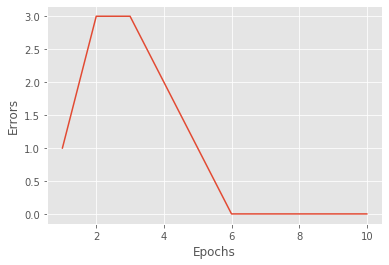

In [16]:
# plot the convergence of errors over time
axes = plt.subplot()
axes.plot(np.arange(1, len(ppn.errors_)+1), ppn.errors_)
axes.set(xlabel='Epochs', ylabel='Errors')
plt.show()

The linear decision boundary generated by the perceptron can be visualized when all points in a 2D area are predicted on and coloured according to their predicted class.

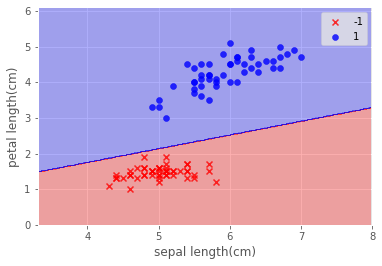

In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # set up colours and markets
    markers = ['x', 'o', '^', 'v']
    colors = ['red', 'blue', 'grey', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # predict each point in 2d feature space and plot as regions of classes
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.stack([xx1.ravel(), xx2.ravel()], axis=1))
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    # plot observation
    for i, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha = 0.8,
            c=colors[i],
            marker=markers[i],
            label=cl
        )

plot_decision_regions(X, y, ppn)
plt.xlabel('sepal length(cm)')
plt.ylabel('petal length(cm)')
plt.legend(loc='best');


### Adaline - an improvement on Perceptrons
Adaline is another binary linear classifier that builds on the Perceptron. It makes one key improvement in that it replaces the piecewise update function with a continuous function based on the net input value itself. I.e. now instead of comparing the real classification to the predicted classification the real classification is compared to the net input.

With this continuous activation function we can now form a continuous objective (cost) function. This function represents the value the problem attempts to minimize to achieve optimal classification. That update represents the direction of movement from the current weights that will result in the most reduction in the objective function.

$$\boldsymbol{w} := \boldsymbol{w} - \eta\nabla J(\boldsymbol{w})$$

$$J(\boldsymbol{w}) = \frac{1}{2} \sum_i{(y_i - x_i^Tw)^2}$$

This process of iteratively moving in the opposite direction of the gradient is called (batch) gradient decent. The step size of each iteration is dependent on the learning rate $\eta$ as well as the magnitude of the gradient (steeper the gradient the larger the step).

Another distinction is that whereas before all weights would be updated after each observation here all weights are updated using ALL observations, i.e. as a batch.

Process is now:
+ Use all observations to compute the partial derivatives of the objective function at $\boldsymbol{w}$
+ Update all weights


#### Adaline Implementation

In [35]:
class AdalineGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        # set random state based on seed
        rgen = np.random.RandomState(self.random_state)
        # initialize weights to small numbers around 0
        self.w_ = rgen.normal(loc=0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        # batch decent n_iter times
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            error = (y - output)
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            cost = (error ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
        

class AdalineSGD(AdalineGD):
    def __init__(self, eta=0.01, n_iter=50, random_state=1, shuffle=True):
        super().__init__(eta, n_iter, random_state)
        self.shuffle = shuffle
        self.w_initialized = False

    def fit(self, X, y):
        # stochastic gradient decent means that for each observation in the training set
        # the weights will be adjusted using just that observation (not entire dataset)
        # done n_iter times in total

        self._initalize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            costs = []
            if self.shuffle:
                X, y = self._shuffle(X, y)
            for xi, target in zip(X, y):
                costs.append(self._update_weights(xi, target))
            self.cost_.append(sum(costs) / len(y))
        
        return self

    def partial_fit(X, y):
        # just update weights based on new observations without resetting
        # previous weights
        if not self.w_initialized:
            self._initalize_weights(X.shape[1])

        # account for single observations streaming case
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)

        return self

    def _initalize_weights(self, p):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+p)
        self.w_initialized = True
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = target - output
        cost = 0.5 * error ** 2

        self.w_[0] += self.eta * error
        self.w_[1:] += self.eta * xi.dot(error)

        return cost



In [19]:
# class interitance example using parent contructor
class a:
    def __init__(self, x):
        print(x)

class b(a):
    def __init__(self, x, y):
        super().__init__(x)
        self.y = y

obj = b(9,10)
obj.y

9


10

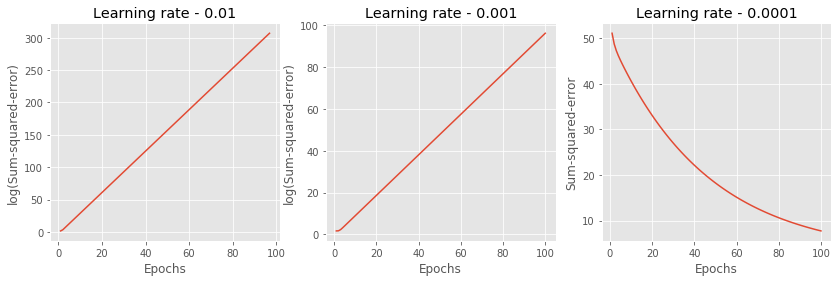

In [32]:
# see the effect of the learning rate on the classifier's convergence
def plot_learning_rates(rates, X, y, classifier, n_iter=100):
    classifiers = [classifier(n_iter=n_iter, eta=rate).fit(X,y) for rate in rates]
    fig, axes = plt.subplots(nrows=1, ncols=len(rates), figsize=(14,4))
    y_labels = [
        'log(Sum-squared-error)',
        'Sum-squared-error'
    ]

    for i, ax in enumerate(axes):
        log_flag = True if classifiers[i].cost_[-1] > classifiers[i].cost_[0] else False   
        axes[i].plot(
            range(1, n_iter + 1), 
            classifiers[i].cost_ if not log_flag else np.log10(classifiers[i].cost_)
            )
        axes[i].set_title(f"Learning rate - {classifiers[i].eta}")
        axes[i].set_ylabel(y_labels[1] if not log_flag else y_labels[0])
        axes[i].set_xlabel("Epochs")
    
    plt.show()

plot_learning_rates([0.01, 0.001, 0.0001], X, y, AdalineGD)

Selecting an appropriate learning rate will mean finding the balance between overshooting the global minimum and slow convergence. In the first two examples above the SSE actually increases from iteration to iteration as the gradient descent overshoots the minimum. The last example actually converges to the solution but requires a large number of epochs since the learning rate is so small.

This downside can be mitigated through proper feature engineering, namely feature scaling. Standardization is the process of giving the data a standard normal distribution i.e each feature is transformed to mean 0 and std of 1.

In [21]:
# utility function to standardize features
def standardize(X):
    X_std = np.copy(X)
    X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

X_std = standardize(X)

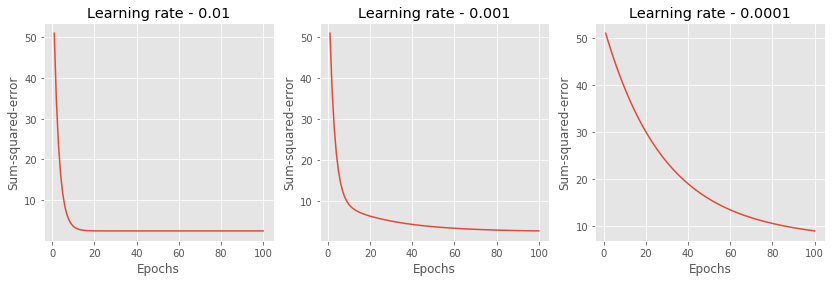

In [33]:
plot_learning_rates([0.01, 0.001, 0.0001], X_std, y, AdalineGD)

Notice how how even at the highest 0.01 learning rate the model converges to the optimal solution.

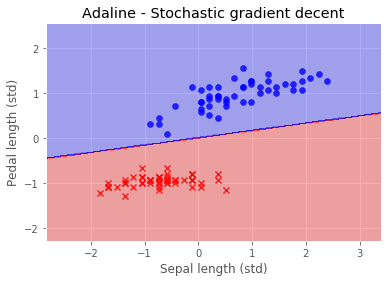

In [31]:
ada_sgd = AdalineSGD().fit(X_std, y)
plot_decision_regions(X_std, y, ada_sgd)
ax = plt.gca()
ax.set_title("Adaline - Stochastic gradient decent")
ax.set_ylabel("Pedal length (std)")
ax.set_xlabel("Sepal length (std)")
plt.show()

Stochastic gradient decent is only an approximation of batch decent so the path of traversal is a lot more sporadic. This actually ends up helping avoid local minima.

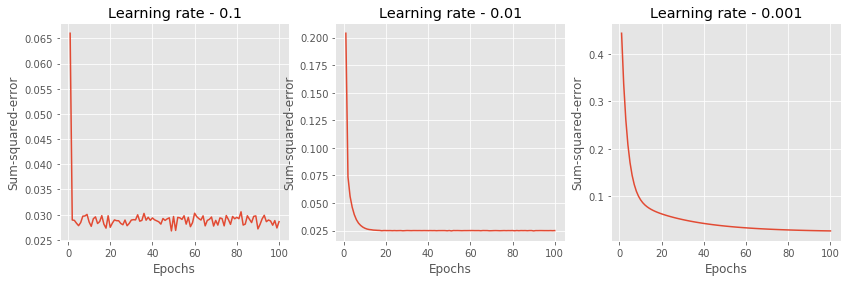

In [37]:
plot_learning_rates([0.1, 0.01, 0.001], X_std, y, AdalineSGD)